In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Sequential, Model, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

In [3]:
# Parameter Eksperimen
img_size = 224  # Ukuran gambar (224x224 untuk MobileNetV2)
batch_size = 32
epochs = 50
learning_rate = 0.0001  # Learning rate lebih kecil untuk transfer learning
optimizer_choice = "adam"

In [4]:
# Path dataset
base_dir = "Dataset_Seimbang_Split"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

In [5]:
# Augmentasi dan preprocessing data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest",
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Membaca data train
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
)

# Membaca data test
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 3855 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [6]:
# Hitung jumlah kelas
num_classes = len(train_generator.class_indices)

# Memuat model pretrained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Membekukan semua layer pretrained
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# Menambahkan layer kustom untuk klasifikasi
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Output sesuai jumlah kelas
])

# Kompilasi model
model.compile(optimizer=optimizers.Adam(learning_rate),
            loss="categorical_crossentropy",
            metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
# Early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Training model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    verbose=1,
    callbacks=[early_stopping],
)

/Users/bayusetia/Downloads/BioFace-Model/env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 44s 345ms/step - accuracy: 0.4019 - loss: 1.3835 - val_accuracy: 0.7469 - val_loss: 0.6913
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 48s 391ms/step - accuracy: 0.6998 - loss: 0.7793 - val_accuracy: 0.8182 - val_loss: 0.5522
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 43s 356ms/step - accuracy: 0.7379 - loss: 0.6648 - val_accuracy: 0.8337 - val_loss: 0.4877
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 43s 354ms/step - accuracy: 0.7620 - loss: 0.6143 - val_accuracy: 0.8419 - val_loss: 0.4462
Epoch 5/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 45s 370ms/step - accuracy: 0.8103 - loss: 0.5288 - val_accuracy: 0.8450 - val_loss: 0.4217
Epoch 6/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 47s 392ms/step - accuracy: 0.8153 - loss: 0.4920 - val_accuracy: 0.8574 - val_loss: 0.4109
Epoch 7/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 48s 393ms/step - accuracy: 0.8281 - loss: 0.4807 - val_accuracy: 0.8605 - val_loss: 0.3904
Epoch 8/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 52s 430ms/step - accuracy: 0.8335 - loss: 0

In [9]:
# Fine-tuning (buka beberapa layer terakhir)
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Membekukan sebagian besar layer pretrained
    layer.trainable = False

# Kompilasi ulang dengan learning rate lebih kecil
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
            loss="categorical_crossentropy",
            metrics=["accuracy"])

# Lanjutkan training
history_fine_tune = model.fit(
    train_generator,
    epochs=epochs // 2,  # Lebih sedikit epoch untuk fine-tuning
    validation_data=test_generator,
    verbose=1,
    callbacks=[early_stopping],
)

Epoch 1/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 52s 403ms/step - accuracy: 0.7630 - loss: 0.6634 - val_accuracy: 0.8833 - val_loss: 0.3522
Epoch 2/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 49s 402ms/step - accuracy: 0.8483 - loss: 0.4278 - val_accuracy: 0.8781 - val_loss: 0.3821
Epoch 3/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 47s 385ms/step - accuracy: 0.8523 - loss: 0.3937 - val_accuracy: 0.8843 - val_loss: 0.3594
Epoch 4/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 48s 394ms/step - accuracy: 0.8776 - loss: 0.3388 - val_accuracy: 0.8843 - val_loss: 0.3596
Epoch 5/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 54s 442ms/step - accuracy: 0.8936 - loss: 0.3091 - val_accuracy: 0.8936 - val_loss: 0.3270


In [10]:
# Simpan model
model.save(f"TF_Model/TransferLearning_MobileNetV2_FaceDiseaseModel.h5")

In [11]:
# Evaluasi model
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"Test Accuracy: {test_acc}")

31/31 - 9s - 283ms/step - accuracy: 0.8833 - loss: 0.3522
Test Accuracy: 0.8832644820213318


In [12]:
# Prediksi pada data uji
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Menghitung metrik evaluasi
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
mse = mean_squared_error(y_true, y_pred_classes)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 288ms/step
Accuracy: 0.8833
Precision: 0.8964
Recall: 0.8833
F1 Score: 0.8850
Mean Squared Error: 0.3275


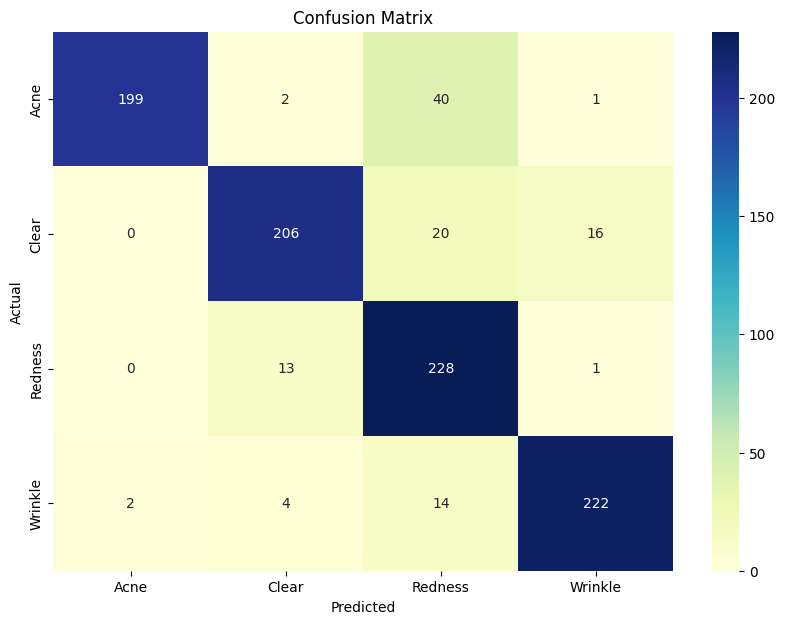

In [13]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
df_cm = pd.DataFrame(cm, index=train_generator.class_indices.keys(), columns=train_generator.class_indices.keys())
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

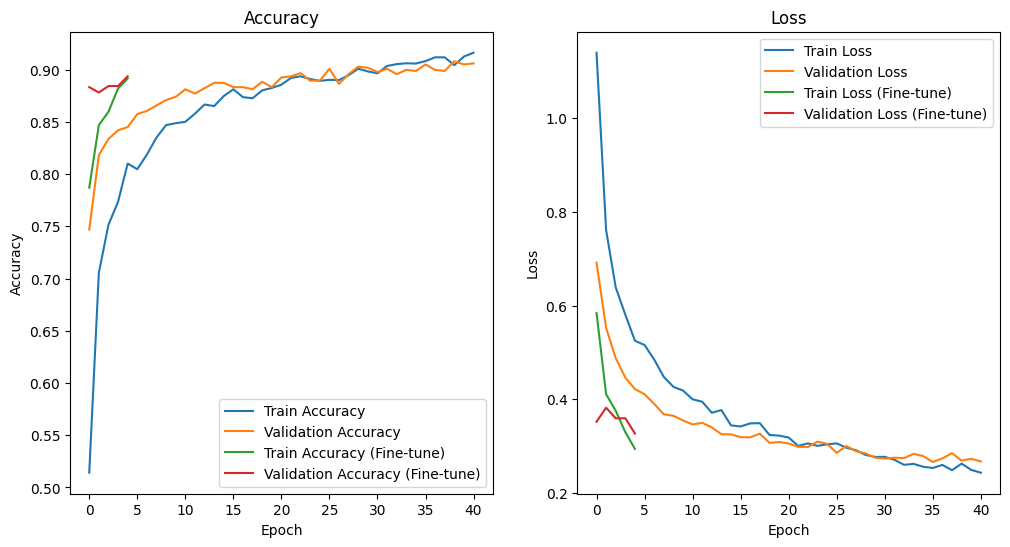

In [14]:
# Visualisasi hasil training
plt.figure(figsize=(12, 6))
# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.plot(history_fine_tune.history["accuracy"], label="Train Accuracy (Fine-tune)")
plt.plot(history_fine_tune.history["val_accuracy"], label="Validation Accuracy (Fine-tune)")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.plot(history_fine_tune.history["loss"], label="Train Loss (Fine-tune)")
plt.plot(history_fine_tune.history["val_loss"], label="Validation Loss (Fine-tune)")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()